In [10]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier  # model ONLY

# paths
CSV_PATH = "data/data.csv"   # expects columns: text, label, src  (we'll use only label)
X_PATHS = {
    "tfidf":     "data/text_embeddings_tfidf.npy",
    "minilm":    "data/text_embeddings.npy",
    "detective": "data/detective_emb_384.npy",
}

# split + tuning config
TEST_RATIO   = 0.1
RANDOM_SEED  = 42
INNER_FOLDS  = 3
K_VALUES     = [1, 2, 5, 10]
METRICS      = ["cosine", "euclidean"]
WEIGHTS      = ["uniform", "distance"]

os.makedirs("results", exist_ok=True)


In [11]:
# labels
df = pd.read_csv(CSV_PATH)
assert "label" in df.columns, "data.csv must have a 'label' column"
y = df["label"].to_numpy().astype(int)
n = len(y)
print(f"Loaded labels: {y.shape}, positives={y.sum()}")

# embeddings (must align row-by-row with data.csv)
X = {}
for name, path in X_PATHS.items():
    arr = np.load(path)
    assert arr.ndim == 2 and arr.shape[0] == n, f"{name}: {arr.shape} does not match labels {n}"
    X[name] = arr
    print(f"{name}: shape={arr.shape}, dtype={arr.dtype}, has_nan={np.isnan(arr).any()}, has_inf={np.isinf(arr).any()}")


Loaded labels: (10000,), positives=3545
tfidf: shape=(10000, 384), dtype=float64, has_nan=False, has_inf=False
minilm: shape=(10000, 384), dtype=float32, has_nan=False, has_inf=False
detective: shape=(10000, 384), dtype=float32, has_nan=False, has_inf=False


In [12]:
def confusion_matrix_binary(y_true, y_pred):
    y_true = y_true.astype(int); y_pred = y_pred.astype(int)
    tp = int(((y_true==1)&(y_pred==1)).sum())
    tn = int(((y_true==0)&(y_pred==0)).sum())
    fp = int(((y_true==0)&(y_pred==1)).sum())
    fn = int(((y_true==1)&(y_pred==0)).sum())
    return tn, fp, fn, tp

def accuracy(y_true, y_pred):
    return float((y_true == y_pred).mean())

def precision_recall_f1(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix_binary(y_true, y_pred)
    prec = tp / (tp + fp) if (tp+fp)>0 else 0.0
    rec  = tp / (tp + fn) if (tp+fn)>0 else 0.0
    f1   = 2*prec*rec / (prec+rec) if (prec+rec)>0 else 0.0
    return prec, rec, f1

def roc_auc_score_binary(y_true, scores):
    # AUC via rank-sum (no external metrics)
    y_true = y_true.astype(int)
    pos = int(y_true.sum()); neg = len(y_true) - pos
    if pos==0 or neg==0: return np.nan
    order = np.argsort(scores)
    ranks = np.empty_like(order); ranks[order] = np.arange(1, len(scores)+1)
    rank_sum_pos = int(ranks[y_true==1].sum())
    U = rank_sum_pos - pos*(pos+1)/2
    return float(U / (pos*neg))


In [13]:
def stratified_train_test_split(y, test_ratio=0.2, seed=42):
    rng = np.random.default_rng(seed)
    y = y.astype(int)
    idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)

    t0 = int(round(len(idx0)*test_ratio))
    t1 = int(round(len(idx1)*test_ratio))

    test_idx = np.concatenate([idx0[:t0], idx1[:t1]])
    train_idx = np.setdiff1d(np.arange(len(y)), test_idx, assume_unique=False)

    # shuffle indices for randomness
    rng.shuffle(train_idx); rng.shuffle(test_idx)
    return train_idx, test_idx

train_idx, test_idx = stratified_train_test_split(y, TEST_RATIO, RANDOM_SEED)
print("Train size:", len(train_idx), "Test size:", len(test_idx))
print("Train class balance:", dict(zip(*np.unique(y[train_idx], return_counts=True))))
print("Test  class balance:", dict(zip(*np.unique(y[test_idx], return_counts=True))))


Train size: 9000 Test size: 1000
Train class balance: {0: 5809, 1: 3191}
Test  class balance: {0: 646, 1: 354}


In [14]:
def fit_predict_knn(X_train, y_train, X_test, k=5, metric="cosine", weights="uniform"):
    if metric not in ("cosine", "euclidean"): 
        raise ValueError("metric must be 'cosine' or 'euclidean'")
    knn = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=weights)
    knn.fit(X_train, y_train)
    scores = knn.predict_proba(X_test)[:, 1]  # prob of class 1
    y_pred = (scores >= 0.5).astype(int)
    return y_pred, scores


In [15]:
def stratified_kfold_indices(y, k=3, seed=42):
    rng = np.random.default_rng(seed)
    y = y.astype(int)
    idx0 = np.where(y==0)[0]; idx1 = np.where(y==1)[0]
    rng.shuffle(idx0); rng.shuffle(idx1)
    f0 = np.array_split(idx0, k); f1 = np.array_split(idx1, k)
    folds = []
    for i in range(k):
        va_idx = np.concatenate([f0[i], f1[i]])
        tr_idx = np.setdiff1d(np.arange(len(y)), va_idx, assume_unique=False)
        folds.append((tr_idx, va_idx))
    return folds

def inner_cv_tune_train_only(Xtr, ytr, k_inner=3, seed=42):
    folds = stratified_kfold_indices(ytr, k=k_inner, seed=seed)
    best = {"score": -1.0, "params": None}
    for K in K_VALUES:
        for metric in METRICS:
            for weights in WEIGHTS:
                f1s = []
                for tr_idx, va_idx in folds:
                    y_pred, _ = fit_predict_knn(
                        Xtr[tr_idx], ytr[tr_idx], Xtr[va_idx],
                        k=K, metric=metric, weights=weights
                    )
                    _, _, f1 = precision_recall_f1(ytr[va_idx], y_pred)
                    f1s.append(f1)
                mean_f1 = float(np.mean(f1s))
                if mean_f1 > best["score"]:
                    best = {"score": mean_f1, "params": {"k": K, "metric": metric, "weights": weights}}
    return best["params"], best["score"]


In [16]:
records = []
per_embed_confmats = {}

for name, Xmat in X.items():
    print(f"\n===== {name.upper()} =====")
    Xtr, Xte = Xmat[train_idx], Xmat[test_idx]
    ytr, yte = y[train_idx], y[test_idx]

    # tune on training set only (3-fold manual CV)
    params, inner_f1 = inner_cv_tune_train_only(Xtr, ytr, k_inner=INNER_FOLDS, seed=RANDOM_SEED)
    print("Best (train-CV):", params, " | mean F1:", round(inner_f1, 4))

    # fit on all training, evaluate on test
    y_pred, scores = fit_predict_knn(Xtr, ytr, Xte, **params)
    tn, fp, fn, tp = confusion_matrix_binary(yte, y_pred)
    acc = accuracy(yte, y_pred)
    prec, rec, f1 = precision_recall_f1(yte, y_pred)
    auc = roc_auc_score_binary(yte, scores)

    print(f"TEST — acc={acc:.4f}  prec={prec:.4f}  rec={rec:.4f}  f1={f1:.4f}  auc={auc:.4f}")

    records.append({
        "embedding": name, "k": params["k"], "metric": params["metric"], "weights": params["weights"],
        "inner_cv_f1": inner_f1, "test_acc": acc, "test_prec": prec, "test_rec": rec, "test_f1": f1, "test_auc": auc
    })
    per_embed_confmats[name] = (tn, fp, fn, tp)

results_df = pd.DataFrame(records).sort_values("test_f1", ascending=False)
results_df.to_csv("results/knn_train_test_results.csv", index=False)
results_df



===== TFIDF =====
Best (train-CV): {'k': 2, 'metric': 'cosine', 'weights': 'uniform'}  | mean F1: 0.551
TEST — acc=0.6260  prec=0.4793  rec=0.6554  f1=0.5537  auc=0.6509

===== MINILM =====
Best (train-CV): {'k': 2, 'metric': 'cosine', 'weights': 'uniform'}  | mean F1: 0.5446
TEST — acc=0.6240  prec=0.4780  rec=0.6751  f1=0.5597  auc=0.6534

===== DETECTIVE =====
Best (train-CV): {'k': 10, 'metric': 'cosine', 'weights': 'uniform'}  | mean F1: 0.7265
TEST — acc=0.8160  prec=0.7607  rec=0.7006  f1=0.7294  auc=0.8753


,embedding,k,metric,weights,inner_cv_f1,test_acc,test_prec,test_rec,test_f1,test_auc
2,detective,10,cosine,uniform,0.726483,0.816,0.760736,0.700565,0.729412,0.875300
1,minilm,2,cosine,uniform,0.544619,0.624,0.478000,0.675141,0.559719,0.653430
0,tfidf,2,cosine,uniform,0.551029,0.626,0.479339,0.655367,0.553699,0.650894


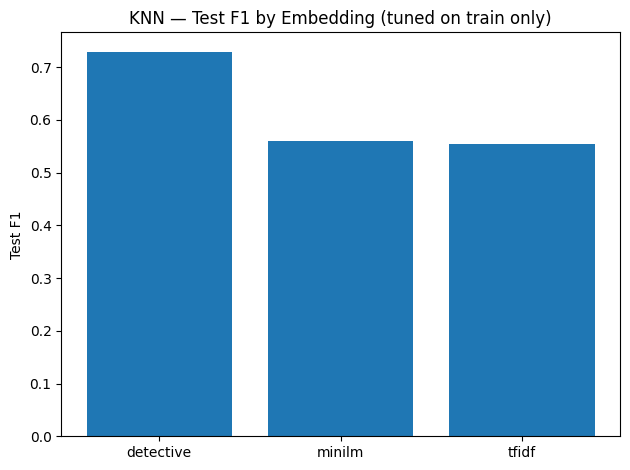

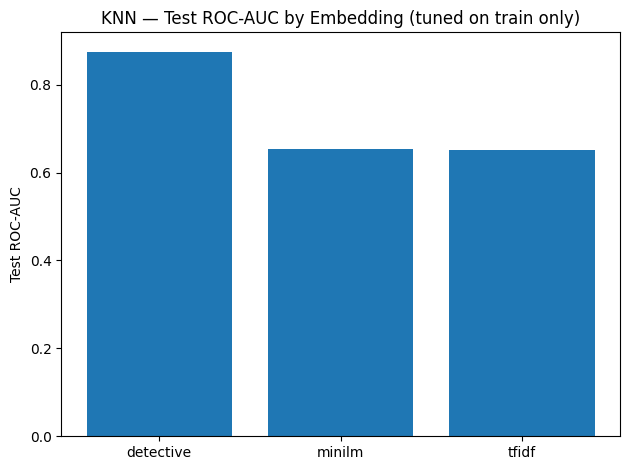

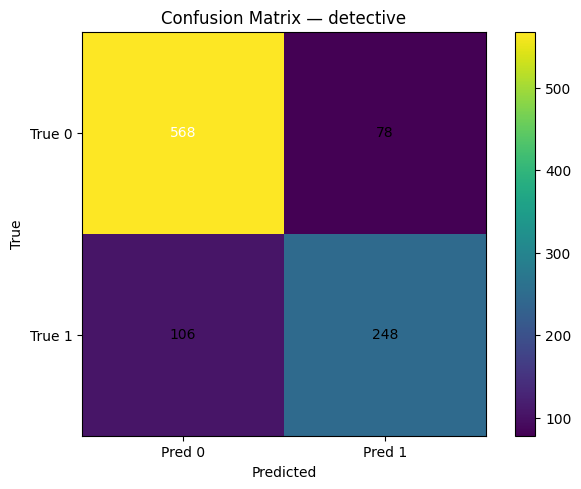

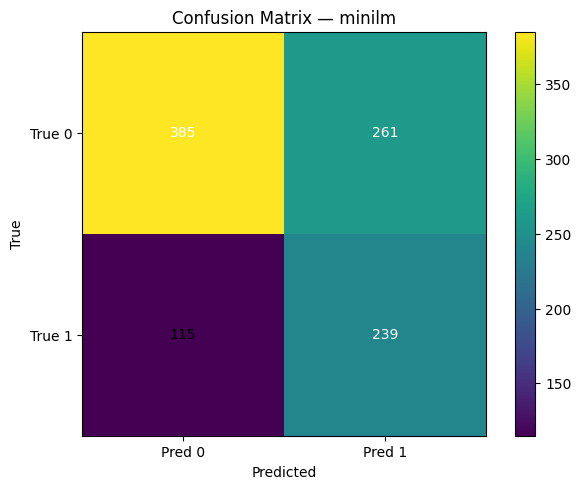

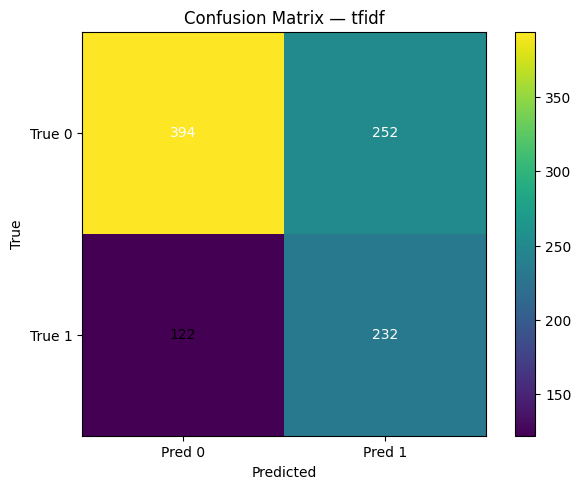

In [17]:
# 1) Bar chart: Test F1
plt.figure()
x = np.arange(len(results_df))
plt.bar(x, results_df["test_f1"])
plt.xticks(x, results_df["embedding"])
plt.ylabel("Test F1")
plt.title("KNN — Test F1 by Embedding (tuned on train only)")
plt.tight_layout(); plt.show()

# 2) Bar chart: Test ROC-AUC
plt.figure()
x = np.arange(len(results_df))
auc_vals = np.nan_to_num(results_df["test_auc"].values, nan=0.0)
plt.bar(x, auc_vals)
plt.xticks(x, results_df["embedding"])
plt.ylabel("Test ROC-AUC")
plt.title("KNN — Test ROC-AUC by Embedding (tuned on train only)")
plt.tight_layout(); plt.show()

# 3) Confusion matrices (per embedding)
for name in results_df["embedding"]:
    tn, fp, fn, tp = per_embed_confmats[name]
    cm = np.array([[tn, fp],[fn, tp]])

    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix — {name}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Pred 0","Pred 1"])
    plt.yticks(tick_marks, ["True 0","True 1"])
    # annotate
    thresh = cm.max() / 2.0
    for i in range(2):
        for j in range(2):
            plt.text(j, i, cm[i, j], ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
